# Visualize runs

In [34]:
# run directory where results where stored
run_directory = 'results/original_start_from_dataset/'

## Results including single runs

In [35]:
!pip install guacamol
import json
import os
import pickle
from collections import defaultdict
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem

from plot_utils import *
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import copy
import re 
from utils import *

params = {
    'font.size': 18,
    'legend.fontsize': 18,
    'text.usetex': False,
}
rcParams.update(params)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [36]:
def plot_wrapper(preds_internal, primitive, name, col_dict, legend_dict, ls_dict, alpha_dict, skip=[], xlabel=None, ylabel=None, ax=None, legend=True, leg_lw=3, **kwargs):
    if ax is not None:
        plt.sca(ax)
    for k, pred in preds_internal.items():
        if k in skip:
            continue
        primitive(
            pred, color=col_dict[k], label=legend_dict[k], ls=ls_dict[k], alpha=alpha_dict[k], **kwargs)

    if legend:
        leg = plt.legend(loc='upper center', bbox_to_anchor=(
            0.5, 1.14), ncol=3, frameon=False)
        for line in leg.get_lines():
            line.set_linewidth(leg_lw)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def median_score_compound(pred, color=None, label=None, shade=False, alpha=.1, **kwargs):
    # pred is triply nested list [n_runs, n_epochs, n_mol(variable_size) ]
    # get mean scores over runs
    pred_mean = np.array([[np.mean([z for z in y if z is not None]) for y in x] for x in pred]).T
    median = np.median(pred_mean, 1)
    q25 = np.percentile(pred_mean, 25, axis=1)
    q75 = np.percentile(pred_mean, 75, axis=1)

    plt.plot(median, c=color, label=label, **kwargs)

    plt.fill_between(
        np.arange(median.shape[0]), q25, q75, alpha=alpha, color=color)
    
def median_score_single(pred, color=None, label=None, alpha=.1, **kwargs):
    medians = np.array([[np.median([t for t in y if t is not None]) for y in x] for x in pred])
    q25 = np.array([[np.percentile([t for t in y if t is not None], 25) for y in x] for x in pred])
    q75 = np.array([[np.percentile([t for t in y if t is not None], 75) for y in x] for x in pred])
    n_runs = medians.shape[0]
    for i in range(n_runs):
        plt.plot(medians[i], c=color, label=label, **kwargs)
        label = None  # avoid multiple legend entries
        plt.fill_between(
            np.arange(medians[i].shape[0]), q25[i], q75[i], alpha=alpha, color=color)

In [37]:
results_dir = Path(run_directory)
figure_dir = Path('figures')
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

write = False
columns = ['AssayID', 'TargetName', 'TargetID']
rows = [('CHEMBL3888429', 'JAK2', 'CHEMBL2971'),
        ('CHEMBL1909203', 'EGFR', 'CHEMBL203'),
        ('CHEMBL1909140', 'DRD2', 'CHEMBL217'),
        ('CHEMBL1794345', 'Pla. Fal.', 'CHEMBL364'),
        ('CHEMBL1741322', 'Cytochrome', 'CHEMBL3356'),
        ('CHEMBL1963961', 'CCRF-CEM', 'CHEMBL382')]
assay_info = pd.DataFrame(rows, columns=columns)
# display(assay_info)

# dictionary to convert chemblID to readable name
chid2name = dict(zip(assay_info['AssayID'], assay_info['TargetName']))

# The predictions for OS, MCS and DCS are saved in dictionaries with these keys
# These dictionaries map these identifiers to more readable strings, colors/linestyles used in plots
order = ('Split1', 'Split1_alt', 'Split2')
legend_dict = dict(zip(order, [r'$S_{opt}$', r'$S_{mc}$', r'$S_{dc}$']))
opt_dict = {'graph_ga': 'Graph GA', 'lstm_hc': 'LSTM', 'mso': 'MSO'}
col_dict = dict(zip(order, ['blue', 'green', 'red']))
col_dict2 = dict(zip(order, ['cyan', 'magenta', 'green']))
ls_dict = dict(zip(order, ['-', '--', '-.']))

# get chembl identifiers used in experiments
# go one step down in tree to get the name of some optimizer ('graph_ga' or 'lstm_hc')
chids = sorted(os.listdir(run_directory + 'graph_ga'))

# get mean and std of all the classifiers trained for dataset
optimizers = sorted([o.name for o in results_dir.iterdir() if o.is_dir()])

# Single runs analysis

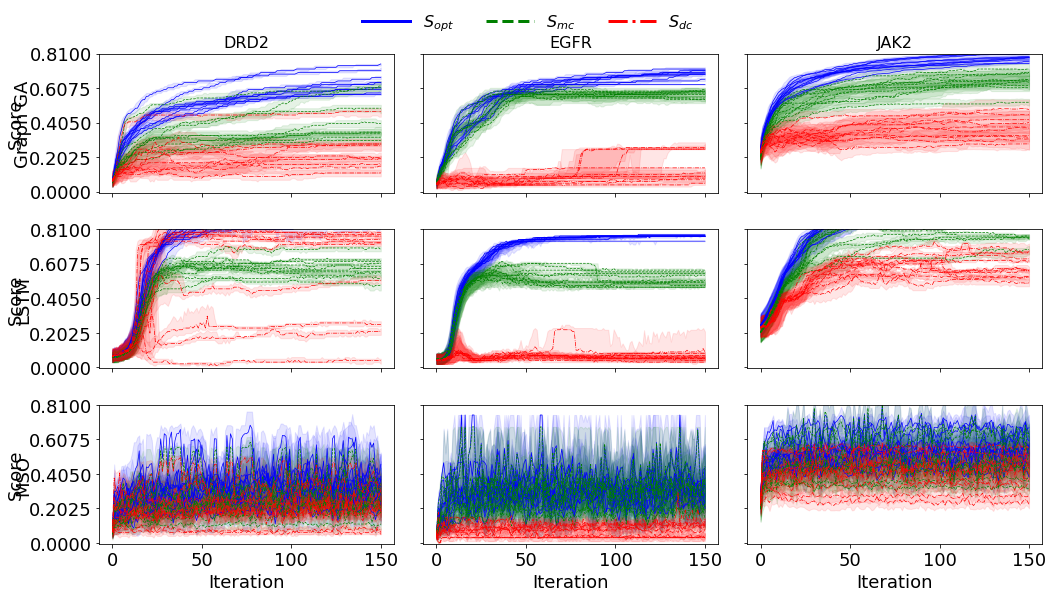

In [38]:
auc_title = False # whether or not to include auc in plot
lw = 0.7 # line width
nrows = 3 # for two optimizers
ncols = len(chids) # for the number of tasks


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 2.75*nrows), sharex=True, sharey=True)
for r_idx, optimizer in enumerate(optimizers):
    for c_idx, chid in enumerate(chids):
        ax = axes[r_idx][c_idx]
        preds_internal, preds_external, auc, _, _ = load_chid(
            results_dir/optimizer/chid, order)
        
        plot_wrapper(preds_internal, median_score_single, name='median_score_single', col_dict=col_dict, legend_dict=legend_dict, ls_dict=ls_dict, alpha_dict = dict(zip(order, [0.1, 0.1, 0.1])), ax=ax, legend=False, lw=lw)
        
        # makes ticks a bit prettier and always makes them at multiples of 0.2
        low, high = ax.set_ylim()
        #yticks = np.arange(round(low/0.2) * 0.2, round(high/0.2) * 0.2 +0.01, 0.2)
        yticks = np.linspace(round(low/0.2) * 0.2, round(high/0.2) * 0.2 +0.01, 5)
        ax.set_yticks(yticks)

# set axes labels 
for i in range(nrows):
    axes[i][0].set_ylabel('Score')
    
for i in range(ncols):
    axes[-1][i].set_xlabel('Iteration')

# set titles to denote tasks
for i, chid in enumerate(chids):
    title = chid2name.get(chid, chid)
    #title += f' ({aucs[chid][0]:.2f})'
    axes[0][i].set_title(title, fontsize=16)

# create legend
custom_lines = [Line2D([0], [0], color=col_dict[k], lw=3, ls=ls_dict[k]) for k in col_dict.keys()]
lgd = fig.legend(custom_lines, list(legend_dict.values()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.03), frameon=False, fontsize=16,handlelength=3)

# add optimizer info by adding text
text_fields = []
xtext = -55
for i, optimizer in enumerate(optimizers):
    txt = axes[i][0].text(xtext, sum(axes[i][0].get_ylim()) /2 , opt_dict[optimizer], rotation=90, verticalalignment='center')
    text_fields.append(txt)
    
fig.tight_layout()

if write or True:
    plt.savefig('figures/median_scores_trajectories.pdf', bbox_extra_artists=[lgd]+text_fields, bbox_inches='tight')

# Averaged runs analysis

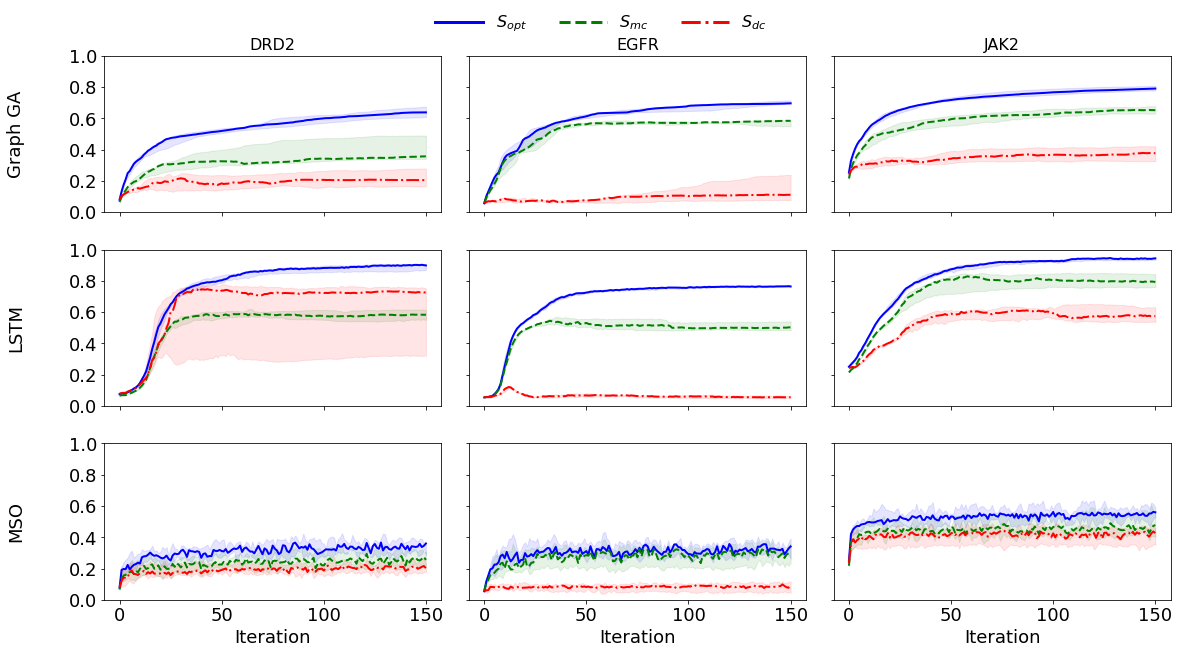

In [39]:
auc_title = False # whether or not to include auc in plot
lw = 2 # line width
nrows = 3 # for two optimizers
ncols = len(chids) # for the number of tasks


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5.5*ncols, 3*nrows), sharex=True, sharey=True)
for r_idx, optimizer in enumerate(optimizers):
    for c_idx, chid in enumerate(chids):
        ax = axes[r_idx][c_idx]
        preds_internal, preds_external, auc, _, _ = load_chid(
            results_dir/optimizer/chid, order)
        
        plot_wrapper(preds_internal, median_score_compound, name='median_score_compound', col_dict=col_dict, alpha_dict = dict(zip(order, [0.1, 0.1, 0.1])), legend_dict=legend_dict, ls_dict=ls_dict, ax=ax, legend=False, lw=lw)
        
        # makes ticks a bit prettier and always makes them at multiples of 0.2
        #ax.set_ylim(0, 1)
        ax.set_ylim(0, 1)
        low, high = 0, 1
        step = (high-low)/5
        yticks = np.arange(round(low/step) * step, round(high/step) * step +0.01, step)
        #yticks = np.linspace(round(low/0.2) * 0.2, round(high/0.2) * 0.2 +0.01, 5)

        ax.set_yticks(yticks)

# set axes labels 
#for i in range(nrows):
#    axes[i][0].set_ylabel('Score')
    
for i in range(ncols):
    axes[-1][i].set_xlabel('Iteration')

# set titles to denote tasks
for i, chid in enumerate(chids):
    title = chid2name.get(chid, chid)
    if auc_title:
        title += f' ({aucs[chid][0]:.2f})'
    axes[0][i].set_title(title, fontsize=16)

# create legend
custom_lines = [Line2D([0], [0], color=col_dict[k], lw=3, ls=ls_dict[k]) for k in col_dict.keys()]
lgd = fig.legend(custom_lines, list(legend_dict.values()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.03), frameon=False, fontsize=16,handlelength=3)

# add optimizer info by adding text
text_fields = []
xtext = -55
for i, optimizer in enumerate(optimizers):
    txt = axes[i][0].text(xtext, sum(axes[i][0].get_ylim()) /2 , opt_dict[optimizer], rotation=90, verticalalignment='center')
    text_fields.append(txt)
    
fig.tight_layout()
plt.savefig('figures/median_scores.pdf', bbox_inches='tight')
